# Constructing a WCS for Overlappogram Data

In [47]:
import numpy as np
import astropy.units as u
import astropy.io.fits
from scipy.io import readsav
import sys
import matplotlib.pyplot as plt
from astropy.visualization import ImageNormalize,LogStretch
import sunpy.map
from sunpy.coordinates import get_earth
import sympy
sys.path.append('../scripts')
from util import (make_moxsi_ndcube, 
                  construct_overlappogram,
                  construct_dispersion_matrix,
                  construct_rot_matrix, 
                  overlappogram_wcs,
                  color_lat_lon_axes)

In [2]:
norm=ImageNormalize(vmin=0,vmax=10,stretch=LogStretch())
cmap='hinodexrt'
plot_props = {'cmap':cmap, 'norm':norm}

## Some Notes on the Formalism

From the `PCi_j` formalism, the conversion between intermediate world coordinates and pixel coordinates is given by (from Gei

$$
x_i = s_iq_i \\
q_i = m_{ij}(p_j - r_j)
$$

The resulting `PC_ij` matrix for our overlappogram **assuming that the dispersion direction is aligned with the y-like pixel axis**,

$$
M_{\alpha} = \begin{bmatrix}
\cos\alpha & \sin\alpha & -\mu\sin\alpha \\
-\sin\alpha & \cos\alpha & -\mu\cos\alpha \\
0 & 0 & 1
\end{bmatrix}
$$

Additionally, we apply an additional rotation by $\gamma$ first in order to align our pixel axis with the dispersion axis,

$$
M_\gamma = \begin{bmatrix}
\cos\gamma & \sin\gamma & 0 \\
-\sin\gamma & \cos\gamma & 0 \\
0 & 0 & 1
\end{bmatrix}
$$

We then rotate our intermediate world coordinate back by $-\gamma$ as the dispersion should not affect the orientation of our world grid.
Thus, our full `PC` matrix can be written as,

$$
M = M_\gamma^TM_\alpha M_\gamma
$$

As an aside, to align the $p_2$ and $q_3$ axes, we would modify the last row of $M$ as, 

$$
\begin{bmatrix}
0 & 0 & 1
\end{bmatrix}
\to
\begin{bmatrix}
-\sin\gamma & \cos\gamma & 0
\end{bmatrix}
$$

This has the effect of decoupling $p_3$ from $q_3$.
This is not strictly correct as a given HPC grid mapped to our 2D pixel axis is only valid at a single wavelength, not all wavelengths.
Aligning $p_2$ and $q_3$ breaks that assumption.


In [54]:
mu = sympy.symbols('mu')
gamma = sympy.symbols('gamma')
alpha = sympy.symbols('alpha')
M_gamma = sympy.Matrix([
    [sympy.cos(gamma), sympy.sin(gamma), 0],
    [-sympy.sin(gamma), sympy.cos(gamma), 0],
    [0, 0, 1]
])
M_alpha = sympy.Matrix([
    [sympy.cos(alpha), sympy.sin(alpha), -mu * sympy.sin(alpha)],
    [-sympy.sin(alpha), sympy.cos(alpha), -mu * sympy.cos(alpha)],
    [0, 0, 1],
])

In [55]:
M_gamma

Matrix([
[ cos(gamma), sin(gamma), 0],
[-sin(gamma), cos(gamma), 0],
[          0,          0, 1]])

In [56]:
M_alpha

Matrix([
[ cos(alpha), sin(alpha), -mu*sin(alpha)],
[-sin(alpha), cos(alpha), -mu*cos(alpha)],
[          0,          0,              1]])

In [63]:
M_tot = M_gamma.T * M_alpha * M_gamma
M_tot.simplify()
M_tot

Matrix([
[ cos(alpha), sin(alpha), -mu*sin(alpha - gamma)],
[-sin(alpha), cos(alpha), -mu*cos(alpha - gamma)],
[          0,          0,                      1]])

We can evaluate the `PCi_j` matrix at a few different combinations of $\alpha,\gamma,\mu$.

In [97]:
for a,g,m in [(0,0,0),
              (0,0,1),
              (sympy.pi/2,0,1),
              (0,sympy.pi/2,1),
              (sympy.pi/2,sympy.pi/2,1),
              (sympy.pi/4,0,1),
              (0,sympy.pi/4,1),
              (sympy.pi/4,sympy.pi/4,1)]:
    print(f'alpha={a}, gamma={g}, mu={m}')
    print('-----------------------------')
    sympy.printing.pprint(M_tot.subs([(alpha, a),(gamma, g),(mu, m)]))

alpha=0, gamma=0, mu=0
-----------------------------
⎡1  0  0⎤
⎢       ⎥
⎢0  1  0⎥
⎢       ⎥
⎣0  0  1⎦
alpha=0, gamma=0, mu=1
-----------------------------
⎡1  0  0 ⎤
⎢        ⎥
⎢0  1  -1⎥
⎢        ⎥
⎣0  0  1 ⎦
alpha=pi/2, gamma=0, mu=1
-----------------------------
⎡0   1  -1⎤
⎢         ⎥
⎢-1  0  0 ⎥
⎢         ⎥
⎣0   0  1 ⎦
alpha=0, gamma=pi/2, mu=1
-----------------------------
⎡1  0  1⎤
⎢       ⎥
⎢0  1  0⎥
⎢       ⎥
⎣0  0  1⎦
alpha=pi/2, gamma=pi/2, mu=1
-----------------------------
⎡0   1  0 ⎤
⎢         ⎥
⎢-1  0  -1⎥
⎢         ⎥
⎣0   0  1 ⎦
alpha=pi/4, gamma=0, mu=1
-----------------------------
⎡ √2   √2  -√2 ⎤
⎢ ──   ──  ────⎥
⎢ 2    2    2  ⎥
⎢              ⎥
⎢-√2   √2  -√2 ⎥
⎢────  ──  ────⎥
⎢ 2    2    2  ⎥
⎢              ⎥
⎣ 0    0    1  ⎦
alpha=0, gamma=pi/4, mu=1
-----------------------------
⎡       √2 ⎤
⎢1  0   ── ⎥
⎢       2  ⎥
⎢          ⎥
⎢      -√2 ⎥
⎢0  1  ────⎥
⎢       2  ⎥
⎢          ⎥
⎣0  0   1  ⎦
alpha=pi/4, gamma=pi/4, mu=1
-----------------------------
⎡ √2   

## Loading Data

First, load the data into a spectral cube, where each slice represents a different wavelength.

In [3]:
savdata = readsav('../data/forDan_MOXSI_DATA_09112020_0440_feldman.sav')

In [4]:
_moxsi_cube = make_moxsi_ndcube(savdata['moxsi1_img'],savdata['cubixss_wave']*u.angstrom)

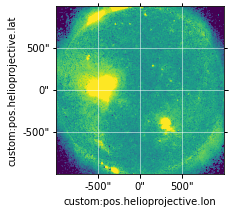

In [5]:
plt.figure(figsize=(3,8))
ax = _moxsi_cube[327].plot(norm=ImageNormalize(vmin=0,vmax=1,stretch=LogStretch()))
lon,lat = ax.coords
lon.grid(color='white', alpha=1, linestyle='solid', lw=.5,)
lat.grid(color='white', alpha=1, linestyle='solid', lw=.5,)

Make the cube sparse here by only including a few wavelengths and filling everything else with 0.
This reduces our need to rotate/shift a bunch of arrays

In [6]:
iw_rank = _moxsi_cube.data.mean(axis=(1,2)).argsort()[::-1]
new_data = np.zeros(_moxsi_cube.data.shape)
for i in iw_rank[:20]:
    new_data[i,:,:] = _moxsi_cube.data[i,:,:]
moxsi_cube = make_moxsi_ndcube(new_data, savdata['cubixss_wave']*u.angstrom)

## Creating the Overlappogram

We can then flatten this to an overlappogram, specifying the roll angle (angle between the pixel and world axes, where 0 corresponds to the y-like pixel axis aligned with latitude) and spectral order.

In [7]:
observer = get_earth()

In [8]:
moxsi_overlap = construct_overlappogram(
    moxsi_cube, 
    roll_angle=0*u.deg,
    dispersion_angle=0*u.deg, 
    observer=observer, 
    order=1,
    correlate_p12_with_wave=False
)

We can then plot the overlappogram at a few different "wavelength slices." Note as we move in wavelength space, our latitude grid shifts along the dispersion axis.

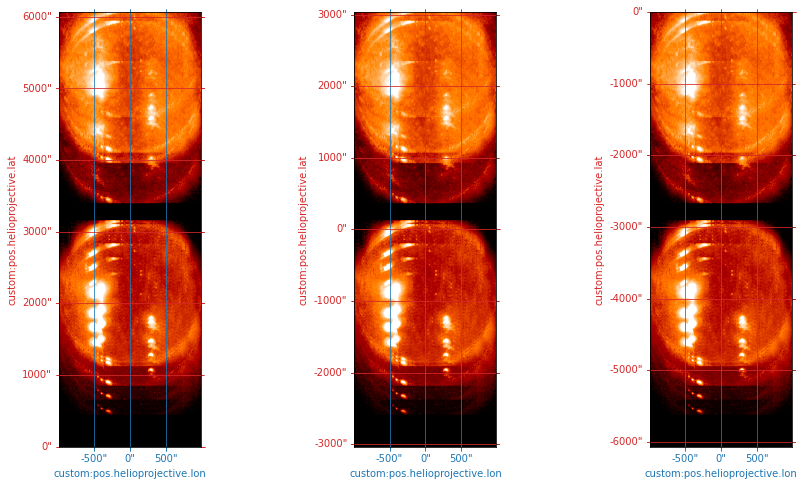

In [9]:
fig = plt.figure(figsize=(15,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap[iw].wcs)
    moxsi_overlap[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})
    #ax.coords[2].set_format_unit(u.angstrom)
    #ax.coords[2].set_major_formatter('x.x')

### Varying Roll Angle

We can also choose to orient the pixel (and thus the dispersion) axis at some non-zero angle relative to the world axes. This is equivalent to "rolling" our satellite.

In [10]:
moxsi_overlap_r45 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=45*u.deg,
    observer=observer,
    order=1
)

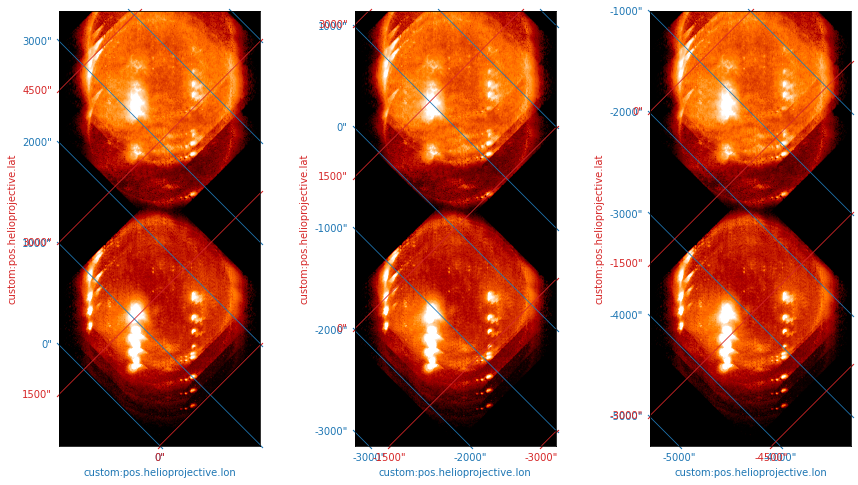

In [11]:
fig = plt.figure(figsize=(15,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap_r45[iw].wcs)
    moxsi_overlap_r45[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,
                           lon_tick_ops={'spacing':1000*u.arcsec},
                           lat_tick_ops={'spacing':1500*u.arcsec})

Or completely in the "longitude" direction

In [12]:
moxsi_overlap_r90 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=90*u.deg,
    observer=observer,
    order=1
)

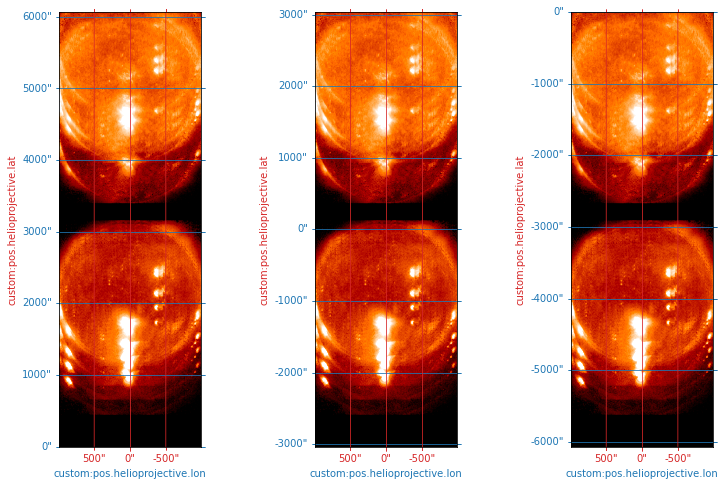

In [13]:
fig = plt.figure(figsize=(13,8))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(1,len(wvl_indices),i+1, projection=moxsi_overlap_r90[iw].wcs)
    moxsi_overlap_r90[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lon_tick_ops={'spacing':1000*u.arcsec})

### Varying Dispersion Angle

We now want to investigate cases where our dispersion angle, the angle between the dispersion axis and the "long" pixel axis, is non-zero.

In [17]:
moxsi_overlap_a0_d5 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=0*u.deg,
    dispersion_angle=5*u.deg,
    observer=observer, 
    order=1,
    correlate_p12_with_wave=True,
)

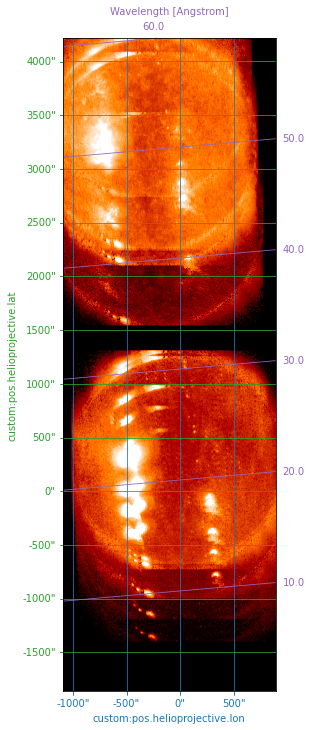

In [19]:
i_w = iw_rank[0]
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(111, projection=moxsi_overlap_a0_d5[i_w].wcs)
moxsi_overlap_a0_d5[i_w].plot(axes=ax,**plot_props)
_ = color_lat_lon_axes(ax,lat_color='C2',
                       lon_tick_ops={'spacing':500*u.arcsec},
                       lat_tick_ops={'spacing':500*u.arcsec})

In [100]:
moxsi_overlap_a45_d10 = construct_overlappogram(
    moxsi_cube, 
    roll_angle=45*u.deg,
    dispersion_angle=10*u.deg,
    observer=observer, 
    order=1,
    correlate_p12_with_wave=False,
)

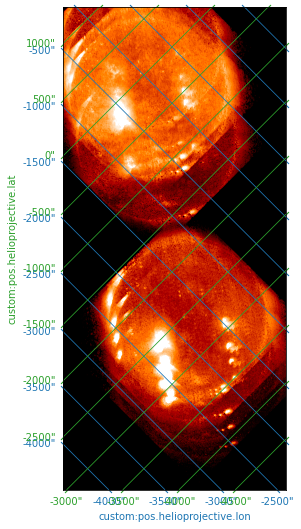

In [101]:
i_w = iw_rank[0] + 600
fig = plt.figure(figsize=(4,12))
ax = fig.add_subplot(111, projection=moxsi_overlap_a45_d10[i_w].wcs)
moxsi_overlap_a45_d10[i_w].plot(axes=ax,**plot_props)
_ = color_lat_lon_axes(ax,lat_color='C2',
                       lon_tick_ops={'spacing':500*u.arcsec},
                       lat_tick_ops={'spacing':500*u.arcsec})

### Varying Spectral Order

In [ ]:
m1 = construct_overlappogram(moxsi_cube,roll_angle=0*u.deg,order=1,observer=observer)
m3 = construct_overlappogram(moxsi_cube,roll_angle=0*u.deg,order=3,observer=observer)

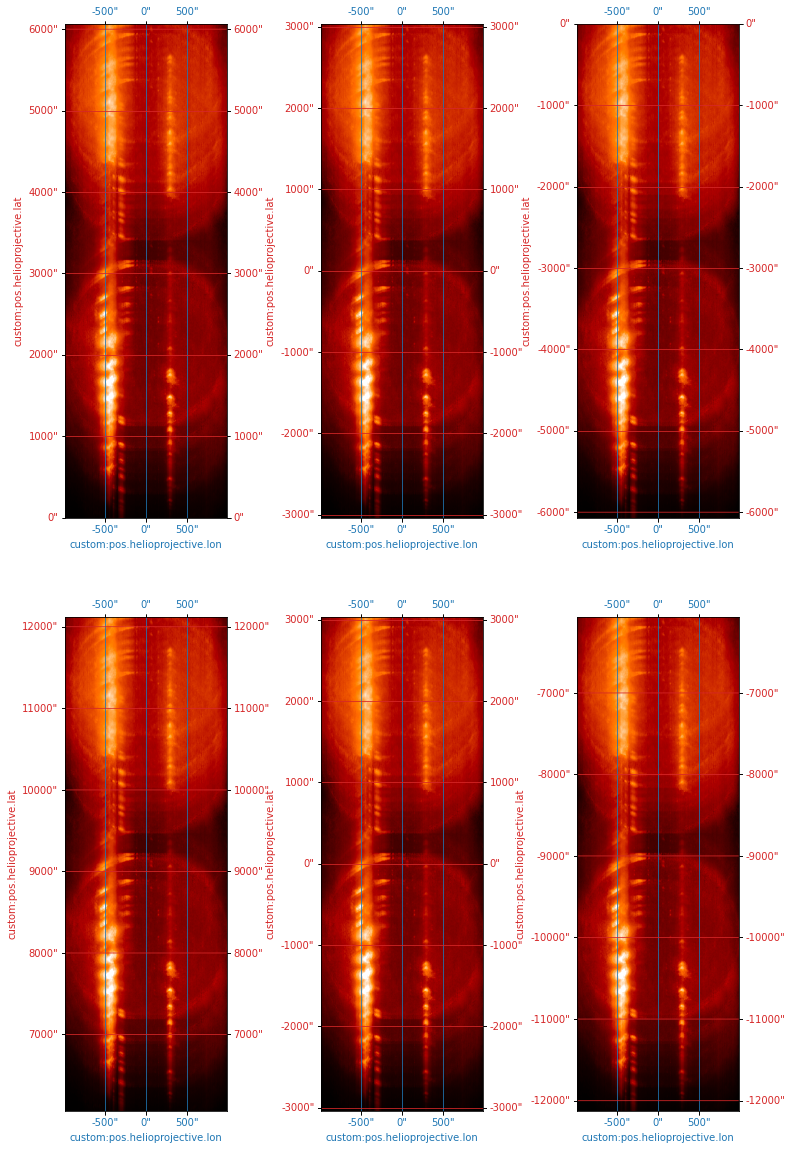

In [ ]:
fig = plt.figure(figsize=(13,20))
wvl_indices = [0,1073//2,1072]
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(2,len(wvl_indices),i+1, projection=m1[iw].wcs)
    m1[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})
for i,iw in enumerate(wvl_indices):
    ax = fig.add_subplot(2,len(wvl_indices),len(wvl_indices)+i+1, projection=m3[iw].wcs)
    m3[iw].plot(axes=ax,**plot_props)
    _ = color_lat_lon_axes(ax,lat_tick_ops={'spacing':1000*u.arcsec})

## Experimenting with FITS Serialization

In [102]:
hdu = astropy.io.fits.ImageHDU(
    data=moxsi_overlap_a45_d10[:1,...].data,
    header=moxsi_overlap_a45_d10.wcs.to_header(),
)
hdu.writeto('../data/overlap-test.fits', overwrite=True, output_verify='ignore')

In [99]:
hdu.header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  496                                                  
NAXIS2  =                 1073                                                  
NAXIS3  =                    1                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
WCSAXES =                    3 / Number of coordinate axes                      
CRPIX1  =                248.5 / Pixel coordinate of reference point            
CRPIX2  =                537.0 / Pixel coordinate of reference point            
CRPIX3  =                537.0 / Pixel coordinate of reference point            
PC1_1   =     0.707106781186

In [ ]:
with astropy.io.fits.open('../data/overlap-test.fits', mode='readonly') as hdul:
    print(len(hdul))
    hdul[1].header

2
